# This notebook is meant to study effects that depends on the lifetime

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import *
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from exp_analysis_class import exp_analysis
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis

In [3]:
hierarchy = 'heavy'
D_or_M = 'dirac'
save_folder = (f'../fig/4_analysis_variables_plots/')
!mkdir -p $save_folder
save_folder = (f'../fig/4_analysis_variables_plots/{hierarchy}_{D_or_M}_')

set_plot_style()

## Use this to load the datasets in the usual way and dump them in pickle files

In [4]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=False,
                                dump=True,
                                load_grid=False)

heavy dirac FHC
loading df base
initialising df base
Wall time: 96.2090470790863 s, CPU time: 85.116041124
heavy dirac RHC
loading df base
initialising df base
Wall time: 98.20098805427551 s, CPU time: 87.15775661599999


## Use the function this way to load the datasets from the pickle files

In [5]:
# my_exp_analyses = load_datasets(hierarchy, D_or_M, 
#                                 timeit=True, 
#                                 direct_load_objects=True,
#                                 load_grid=False)

In [17]:
nu_mode = 'FHC'
df = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base

In [47]:
tpc_index = 2
t_x_min = (tpc_fiducial_volume_endpoints[0][0] - df['int_point_x'])/df['pdark_dir_x']
t_x_max = (tpc_fiducial_volume_endpoints[0][1] - df['int_point_x'])/df['pdark_dir_x']
t_y_min = (tpc_fiducial_volume_endpoints[1][0] - df['int_point_y'])/df['pdark_dir_y']
t_y_max = (tpc_fiducial_volume_endpoints[1][1] - df['int_point_y'])/df['pdark_dir_y']
t_z_min = (tpc_fiducial_volume_endpoints[2][0] + tpc_index * (tpc_outer_volume[2] + fgd_outer_volume[2]) - df['int_point_z'])/df['pdark_dir_z']
t_z_max = (tpc_fiducial_volume_endpoints[2][1] + tpc_index * (tpc_outer_volume[2] + fgd_outer_volume[2]) - df['int_point_z'])/df['pdark_dir_z']
t_exit_s = np.stack([t_x_min, t_x_max, t_y_min, t_y_max, t_z_min, t_z_max], axis=1)

t_x_min_in = exp_analysis.is_point_in_tpc_general((df['int_point_y'] + t_x_min*df['pdark_dir_y'], 
                                                  df['int_point_z'] + t_x_min*df['pdark_dir_z']),
                                                  coords=[1, 2],
                                                  tpc_index=tpc_index)
t_x_max_in = exp_analysis.is_point_in_tpc_general((df['int_point_y'] + t_x_max*df['pdark_dir_y'], 
                                                  df['int_point_z'] + t_x_max*df['pdark_dir_z']),
                                                  coords=[1, 2],
                                                  tpc_index=tpc_index)
t_y_min_in = exp_analysis.is_point_in_tpc_general((df['int_point_x'] + t_y_min*df['pdark_dir_x'], 
                                                  df['int_point_z'] + t_y_min*df['pdark_dir_z']),
                                                  coords=[0, 2],
                                                  tpc_index=tpc_index)
t_y_max_in = exp_analysis.is_point_in_tpc_general((df['int_point_x'] + t_y_max*df['pdark_dir_x'], 
                                                  df['int_point_z'] + t_y_max*df['pdark_dir_z']),
                                                  coords=[0, 2],
                                                  tpc_index=tpc_index)
t_z_min_in = exp_analysis.is_point_in_tpc_general((df['int_point_x'] + t_z_min*df['pdark_dir_x'], 
                                                  df['int_point_y'] + t_z_min*df['pdark_dir_y']),
                                                  coords=[0, 1],
                                                  tpc_index=tpc_index)
t_z_max_in = exp_analysis.is_point_in_tpc_general((df['int_point_x'] + t_z_max*df['pdark_dir_x'], 
                                                  df['int_point_y'] + t_z_max*df['pdark_dir_y']),
                                                  coords=[0, 1],
                                                  tpc_index=tpc_index)

are_t_exit_s_in = np.stack([t_x_min_in, t_x_max_in, t_y_min_in, t_y_max_in, t_z_min_in, t_z_max_in], axis=1)

In [48]:
stat_in_tcp_2d = exp_analysis.is_point_in_tpc_general((df['int_point_x'], df['int_point_y']), coords=[0, 1])

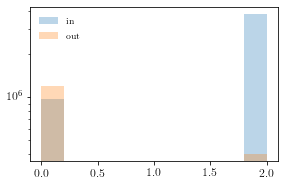

In [49]:
plt.hist(are_t_exit_s_in.sum(axis=1)[stat_in_tcp_2d], label='in', alpha=0.3)
plt.hist(are_t_exit_s_in.sum(axis=1)[~stat_in_tcp_2d], label='out', alpha=0.3)
plt.yscale('log')
plt.legend()

In [19]:
t_exit_s = np.clip(t_exit_s, a_min=0, a_max=None)

In [20]:
out = np.zeros((len(df), 2))

In [21]:
mask = are_t_exit_s_in.sum(axis=1) == 2

In [22]:
aux = t_exit_s[mask][are_t_exit_s_in[mask]]


In [23]:
out[mask] = aux.reshape((-1, 2))

In [24]:
out

array([[  0.        ,   0.        ],
       [293.39129639, 262.0994873 ],
       [259.50628662, 317.80047607],
       ...,
       [  0.        ,   0.        ],
       [  0.        ,  15.12647724],
       [  0.        ,  38.38635635]])

In [25]:
are_t_exit_s_in

array([[False, False, False, False, False, False],
       [ True, False, False, False,  True, False],
       [False, False, False, False,  True,  True],
       ...,
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False,  True,  True]])

In [26]:
t_exit_s[are_t_exit_s_in]

array([293.3913  , 262.0995  , 259.5063  , ...,  15.126477,   0.      ,
        38.386356], dtype=float32)

In [21]:
out = np.where(are_t_exit_s_in.sum(axis=1) == 2,
               t_exit_s,
               np.zeros((len(are_t_exit_s_in), 2)))

ValueError: operands could not be broadcast together with shapes (6387262,) (9185403,) (6387262,2) 

In [ ]:
t_exit_s[~are_t_exit_s_in] = np.inf
t_exit_s = np.sort(t_exit_s, axis=1)

In [9]:
t_exit_x_min = (tpc_fiducial_volume_endpoints[0][0] - df['int_point_x'])/df['pdark_dir_x']
t_exit_x_max = (tpc_fiducial_volume_endpoints[0][1] - df['int_point_x'])/df['pdark_dir_x']
t_exit_y_min = (tpc_fiducial_volume_endpoints[1][0] - df['int_point_y'])/df['pdark_dir_y']
t_exit_y_max = (tpc_fiducial_volume_endpoints[1][1] - df['int_point_y'])/df['pdark_dir_y']
t_exit_s = np.stack([t_exit_x_min, t_exit_x_max, t_exit_y_min, t_exit_y_max], axis=1)

t_exit_x_min_in = exp_analysis.is_point_in_tpc1d(df['int_point_y'] + t_exit_x_min*df['pdark_dir_y'], coord=1)
t_exit_x_max_in = exp_analysis.is_point_in_tpc1d(df['int_point_y'] + t_exit_x_max*df['pdark_dir_y'], coord=1)
t_exit_y_min_in = exp_analysis.is_point_in_tpc1d(df['int_point_x'] + t_exit_y_min*df['pdark_dir_x'], coord=0)
t_exit_y_max_in = exp_analysis.is_point_in_tpc1d(df['int_point_x'] + t_exit_y_max*df['pdark_dir_x'], coord=0)
are_t_exit_s_in = np.stack([t_exit_x_min_in, t_exit_x_max_in, t_exit_y_min_in, t_exit_y_max_in], axis=1)

t_exit_s[~are_t_exit_s_in] = np.inf
t_exit_s = np.sort(t_exit_s, axis=1)

In [10]:


t_tpc_s = np.stack([t_tpc_0, t_tpc_1], axis=1)

are_t_tpc_s_in = exp_analysis.is_point_in_tpc2d(np.expand_dims(df['int_point_x'], [1]) + np.expand_dims(df['pdark_dir_x'], [1])*t_tpc_s,
                                                np.expand_dims(df['int_point_y'], [1]) + np.expand_dims(df['pdark_dir_y'], [1])*t_tpc_s)
t_tpc_s = np.sort(t_tpc_s, axis=1)

In [11]:
t_exit_s_prime = deepcopy(t_exit_s)

In [12]:
t_exit_s_prime[t_exit_s<np.expand_dims(t_tpc_s[:, 0], [1])] = np.inf
t_exit_s_prime[t_exit_s>np.expand_dims(t_tpc_s[:, 1], [1])] = np.inf

In [13]:
t_tpc_s[~are_t_tpc_s_in] = np.inf

In [14]:
out = np.concatenate([t_tpc_s, t_exit_s_prime], axis=1)

In [15]:
out = np.sort(out, axis=1)

In [16]:
out_final = np.where(np.expand_dims((np.isinf(out).sum(axis=1) % 2) != 1,[1]),
         np.clip(out[:, :2], a_min=0, a_max=None),
         np.zeros(out[:, :2].shape))

In [17]:
special_points = (np.isinf(out).sum(axis=1) % 2) == 1

In [18]:
out[special_points]

array([[162.80367, 219.69359, 219.69371,       inf,       inf,       inf],
       [228.16188,       inf,       inf,       inf,       inf,       inf],
       [222.27274,       inf,       inf,       inf,       inf,       inf]],
      dtype=float32)

In [140]:
out[np.isinf(out).sum(axis=1) == 3]

array([[162.80367669, 219.69358113, 219.69373603,          inf,
                 inf,          inf]])

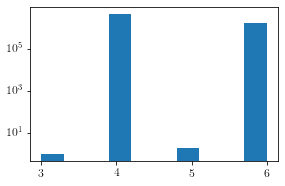

In [141]:
plt.hist(np.isinf(out).sum(axis=1))
plt.yscale('log')

In [108]:
out

array([[ 172.04643019,  231.38278782,           inf,           inf,
                  inf,           inf],
       [ 233.64952594,  291.87055933,           inf,           inf,
                  inf,           inf],
       [-251.46594038, -193.17172861,           inf,           inf,
                  inf,           inf],
       ...,
       [-290.31235442, -233.35244002,           inf,           inf,
                  inf,           inf],
       [-219.84305794, -146.5876743 ,           inf,           inf,
                  inf,           inf],
       [ -20.49187023,   37.51474776,           inf,           inf,
                  inf,           inf]])

In [19]:
howmany_t_tpc_s = are_t_tpc_s_in.sum(axis=1)
one_tpc_in = (howmany_t_tpc_s ==1)

In [73]:
are_t_tpc_s_in[special_event]

array([[False,  True],
       [ True, False]])

In [74]:
t_tpc_s[special_event]

array([[         inf, 228.16188527],
       [222.27272578,          inf]])

In [75]:
t_exit_s[special_event]

array([[  228.1620973 ,  3962.64914207,            inf,            inf],
       [-1595.76092658,   222.27262565,            inf,            inf]])

In [32]:
t_exit_s_prime

array([[inf, inf, inf, inf],
       [inf, inf, inf, inf],
       [inf, inf, inf, inf],
       ...,
       [inf, inf, inf, inf],
       [inf, inf, inf, inf],
       [inf, inf, inf, inf]])

In [33]:
are_t_tpc_s_in[one_tpc_in]

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True, False],
       [False,  True],
       [False,  True]])

In [34]:
t_exit_s_prime[one_tpc_in]

array([[          inf,   52.83818517,           inf,           inf],
       [          inf,   92.2345632 ,           inf,           inf],
       [          inf,  341.60569366,           inf,           inf],
       ...,
       [          inf, -139.2881961 ,           inf,           inf],
       [  -3.47834755,           inf,           inf,           inf],
       [-101.03698033,           inf,           inf,           inf]])

In [35]:
t_tpc_s[one_tpc_in]

array([[  43.1472462 ,  101.83309593],
       [  66.20411976,  149.68790578],
       [ 340.65595905,  422.19948756],
       ...,
       [-147.65573795,  -91.35528156],
       [ -15.21427279,   41.39096035],
       [-151.19518034,  -93.3702302 ]])

In [72]:
special_event = (np.isinf(out).sum(axis=1) == 5)

In [67]:
t_tpc_s[special_event]

array([[162.80367669, 219.69373603]])

In [71]:
t_exit_s[one_tpc_in]

array([[-3.57453563e+02,  5.28381852e+01,             inf,
                    inf],
       [-4.43472094e+02,  9.22345632e+01,             inf,
                    inf],
       [-2.12371864e+02,  3.41605694e+02,             inf,
                    inf],
       ...,
       [-1.03556223e+05, -1.39288196e+02,             inf,
                    inf],
       [-3.47834755e+00,  3.89866742e+03,             inf,
                    inf],
       [-1.01036980e+02,  1.39856720e+03,             inf,
                    inf]], dtype=float128)

In [70]:
t_tpc_s[one_tpc_in]

array([[  43.1472462 ,  101.83309593],
       [  66.20411976,  149.68790578],
       [ 340.65595905,  422.19948756],
       ...,
       [-147.65573795,  -91.35528156],
       [ -15.21427279,   41.39096035],
       [-151.19518034,  -93.3702302 ]], dtype=float128)

In [69]:
are_t_tpc_s_in[one_tpc_in]

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True, False],
       [False,  True],
       [False,  True]])

In [ ]:
condlist = [
            (are_t_tpc_s_in[:, 0] == True) and (are_t_tpc_s_in[:, 1] == True),
            (are_t_tpc_s_in[:, 0] == True) and (are_t_tpc_s_in[:, 1] == False),
            (are_t_tpc_s_in[:, 0] == False) and (are_t_tpc_s_in[:, 1] == True),
            (are_t_tpc_s_in[:, 0] == False) and (are_t_tpc_s_in[:, 1] == False),
           ]

choicelist_in = [
                t_tpc_s[:, 0],
                t_tpc_s[:, 0],
                np.min(t_exit_s>are_t_tpc_s_in[:, 0], axis=1),
                np.min(t_exit_s>are_t_tpc_s_in[:, 0], axis=1),
            ]

choicelist_out = [
                t_tpc_s[:, 1],
                np.min(t_exit_s>are_t_tpc_s_in[:, 0], axis=1),
                t_tpc_s[:, 1],
                np.min(t_exit_s>np.min(t_exit_s>are_t_tpc_s_in[:, 0], axis=1), axis=1),
            ]

### One TPC

In [47]:
one_t_tpc_s_mask = (howmany_t_tpc_s == 1)

In [48]:
aux = (t_exit_s[one_t_tpc_s_mask] > np.expand_dims(t_tpc_s[one_t_tpc_s_mask, 0], [1])) &\
(t_exit_s[one_t_tpc_s_mask] < np.expand_dims(t_tpc_s[one_t_tpc_s_mask, 1], [1]))

In [49]:
one_t_tpc_s_mask.sum()

259652

In [65]:
t_exit_s[one_t_tpc_s_mask]

array([[-3.57453563e+02,  5.28381852e+01,             inf,
                    inf],
       [-4.43472094e+02,  9.22345632e+01,             inf,
                    inf],
       [-2.12371864e+02,  3.41605694e+02,             inf,
                    inf],
       ...,
       [-1.03556223e+05, -1.39288196e+02,             inf,
                    inf],
       [-3.47834755e+00,  3.89866742e+03,             inf,
                    inf],
       [-1.01036980e+02,  1.39856720e+03,             inf,
                    inf]], dtype=float128)

In [50]:
len(t_exit_s[one_t_tpc_s_mask][aux])

259650

In [51]:
points_within = ((t_exit_s > np.expand_dims(t_tpc_s[:, 0], [1])) & (t_exit_s < np.expand_dims(t_tpc_s[:, 1], [1])))

In [52]:
one_point_within_mask = (points_within.sum(axis=1)==1)

In [53]:
one_point_within_mask.shape

(6387262,)

In [54]:
points_within.shape

(6387262, 4)

In [55]:
t_exit_s[one_point_within_mask][points_within[one_point_within_mask]]

array([  52.83818517,   92.2345632 ,  341.60569366, ..., -139.2881961 ,
         -3.47834755, -101.03698033], dtype=float128)

In [56]:
are_t_tpc_s_in[one_point_within_mask]

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True, False],
       [False,  True],
       [False,  True]])

In [57]:
t_tpc_s[one_point_within_mask[are_t_tpc_s_in]]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [58]:
special_points = (one_t_tpc_s_mask != one_point_within_mask)

In [59]:
t_tpc_s[special_points]

array([[162.80367669, 219.69373603],
       [171.6242564 , 228.16188527],
       [222.27272578, 279.04302632]], dtype=float128)

In [60]:
are_t_tpc_s_in[special_points]

array([[ True,  True],
       [False,  True],
       [ True, False]])

In [61]:
t_exit_s[special_points]

array([[-2611.87571366,   219.69358113,            inf,            inf],
       [  228.1620973 ,  3962.64914207,            inf,            inf],
       [-1595.76092658,   222.27262565,            inf,            inf]],
      dtype=float128)

In [62]:
points_within[special_points]

array([[False,  True, False, False],
       [False, False, False, False],
       [False, False, False, False]])

In [63]:
pdark_diff_from_one[special_points]

2263446   -1.325854e-08
2351823    4.993522e-08
4123126   -5.053897e-08
dtype: float128

In [41]:
points_within[this_mask]

array([[False,  True, False, False],
       [False,  True, False, False],
       [False,  True, False, False],
       ...,
       [False,  True, False, False],
       [ True, False, False, False],
       [ True, False, False, False]])

In [42]:
(this_mask != (points_within.sum(axis=1)==1)).sum()

3

In [43]:
(points_within.sum(axis=1)==1).sum()

259883

In [44]:
special_points = this_mask != (points_within.sum(axis=1)==1)

In [47]:
this_mask[special_points]

array([False,  True,  True])

In [45]:
t_tpc_s[special_points]

array([[162.80367779, 219.69373752],
       [171.62425208, 228.16187953],
       [222.27273149, 279.04303349]])

In [48]:
are_t_tpc_s_in[special_points]

array([[ True,  True],
       [False,  True],
       [ True, False]])

In [46]:
t_exit_s[special_points]

array([[-2611.87571366,   219.69358113,            inf,            inf],
       [  228.1620973 ,  3962.64914207,            inf,            inf],
       [-1595.76092658,   222.27262565,            inf,            inf]])

In [49]:
are_t_exit_s_in[special_points]

array([[ True, False,  True, False],
       [ True,  True, False, False],
       [False,  True,  True, False]])

# Detector plot

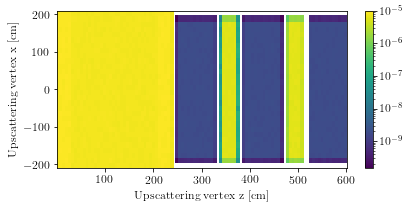

In [5]:
nu_mode = 'FHC'
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']
df = exp_analysis_obj.df_base

this_weights = exp_analysis_obj.compute_pot_ntarget_weights(df, 
                            ntarget_per_material=analyses['tpc'][nu_mode]['n_target'],
                            pot=analyses['tpc'][nu_mode]['pot'])


fig = plt.figure(figsize=(6.5,2.9))
plt.hist2d(df['int_point_z'], df['int_point_x'], 
          bins=(100, 30), weights=this_weights, norm=LogNorm(),
          density=True);
plt.xlabel('Upscattering vertex z [cm]')
plt.ylabel('Upscattering vertex x [cm]')
plt.colorbar()

# plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

In [6]:
# ctaus = np.array([0.5, 0.2, 0.1])
ctaus = np.array([100, 1, 0.01])

nu_mode = 'FHC'
aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=ctaus,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

aux_noctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=None,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

NameError: name 'i' is not defined

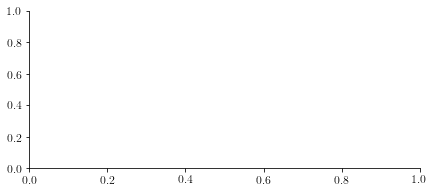

In [7]:
fig = plt.figure(figsize=(7,2.9))

binning = np.linspace(0, 600, 120)
bin_width = binning[1]-binning[0]

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.hist(aux[0]['int_point_z'],
         bins=binning,
         weights=aux[1][:, i]/bin_width,
         histtype='step',
         color=colors[i],
         label=f'c$\\tau^0$ = {ctau:.3g} cm')
plt.legend(frameon=False, ncol=2)
plt.yscale('log')
plt.ylim(1e-5, 2e1)
plt.ylabel(f'Events/{bin_width:.2g} cm')
plt.xlabel('Upscattering vertex [cm]')
plt.xticks(np.linspace(0, 600, 13));
# plt.savefig(save_folder+f'int_vertex_z.pdf', bbox_inches='tight')
plt.hist(aux_noctau[0]['int_point_z'],
         bins=binning,
         weights=aux_noctau[1]/bin_width,
         histtype='step',
         color='navy',
         label='preselection')

colors = ['violet', 'dodgerblue', 'darkorange']
# for i, ctau in enumerate(ctaus):

In [9]:
import kde_utils
from parameters_dict import *

In [21]:
aux_binning = []
for splits in detector_splitting_z.values():
    aux_binning += np.linspace(*splits, 10).tolist()
binning = np.array(aux_binning)

0 30.5
30.5 209.6
209.6 240
250.95 329.05
343.1 373.4
387.45 465.55
479.6 509.9
523.95 602.05


In [55]:
def kde_hist(binning, int_point_z, ctau_weights, smoothing=3):
    aux_kde_w = kde_utils.kde_Nd_weights(np.expand_dims(binning, [1]), np.expand_dims(int_point_z, [1]), 
               smoothing=np.array([smoothing]), distance='lin', kernel='gaus')
    return (aux_kde_w*np.expand_dims(ctau_weights, [1])/bin_width).sum(axis=0)

In [ ]:
fig = plt.figure(figsize=(7,2.9))

binning = np.linspace(0, 600, 120)
bin_width = binning[1]-binning[0]

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.plot(binning, kde_hist(binning, aux[0]['int_point_z'], aux_noctau[1]),
         color='navy',
         label='preselection')

colors = ['violet', 'dodgerblue', 'darkorange']
for i, ctau in enumerate(ctaus):
    plt.plot(binning, kde_hist(binning, aux[0]['int_point_z'], aux[1][:, i]),
             color=colors[i],
             label=f'c$\\tau^0$ = {ctau:.3g} cm')
plt.legend(frameon=False, ncol=2)
plt.yscale('log')
plt.ylim(1e-5, 2e1)
plt.ylabel(f'Events/{bin_width:.2g} cm')
plt.xlabel('Upscattering vertex [cm]')
plt.xticks(np.linspace(0, 600, 13));
# plt.savefig(save_folder+f'int_vertex_z.pdf', bbox_inches='tight')

# Find the c$\tau$ we exclude by varying $V_{ND}$

In [7]:
V_N_2_s = np.geomspace(physics_parameters['heavy']['bp']['Umu4_2'], 1e2, 25)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['Ud4_2'] = V_N_2_s

ctaus = ctau_heavy(m4=this_point['m4'],
                   mz=this_point['mz'], 
                   Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
                   D_or_M=D_or_M)

leff = np.zeros(V_N_2_s.shape)
mu_s = np.zeros(V_N_2_s.shape)
sigma2_s = np.zeros(V_N_2_s.shape)
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=True)
    leff += aux[0]
    mu_s += aux[1]
    sigma2_s += aux[3]

leff -= leff.min()

In [8]:
like_interp = interp1d(ctaus, leff-likelihood_levels_1d[0.9], kind='cubic')
r1 = root_scalar(like_interp, method='brentq', bracket=[1e-2, 1], 
                 fprime=None, fprime2=None, x0=0.2, x1=0.15)
r2 = root_scalar(like_interp, method='brentq', bracket=[1e3, 1e5], 
                 fprime=None, fprime2=None, x0=1e4, x1=2e4)

(-1.0, 1.0)

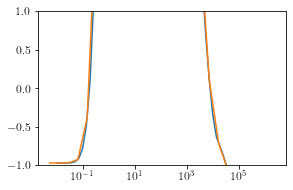

In [9]:
plt.plot(np.geomspace(1e-2, 1e5, 50), like_interp(np.geomspace(1e-2, 1e5, 50)))
plt.plot(ctaus, leff-likelihood_levels_1d[0.9])
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1, 1)

<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-300b5d2cde53>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


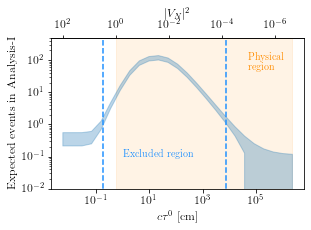

In [10]:
from scipy.interpolate import UnivariateSpline

ax = set_canvas_basic()
ax.set_xlabel('$c\\tau^0$ [cm]')
ax.set_ylabel('Expected events in Analysis-I')
ax.set_xscale('log')
ax.set_yscale('log')

forward_fun = UnivariateSpline(np.log(ctaus[::-1]), np.log(V_N_2_s[::-1]), k=1)
backward_fun = UnivariateSpline(np.log(V_N_2_s), np.log(ctaus), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$|V_N|^2$')
secax.set_ticks

ax.fill_betweenx([1e-2, 1e4], 
                 backward(physics_parameters['heavy']['bp']['Umu4_2']), backward(1), 
                 color='darkorange', alpha=0.1)
ax.annotate('Physical\n region', color='darkorange', xy=(5e4, 5e1))

ax.fill_between(ctaus, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
                color='C0', alpha=0.3, label='number of events')
ax.vlines(r1.root, 0, 1e4, color='dodgerblue', ls='--')
ax.vlines(r2.root, 0, 1e4, color='dodgerblue', ls='--')
ax.annotate('Excluded region', color='dodgerblue', xy=(1, 1e-1))
ax.set_ylim(1e-2, 5e2)

# plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.pdf', bbox_inches='tight')
plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.png', bbox_inches='tight', transparent=True, dpi=500)

## for different $m_N$

In [8]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] = 1e-20

base_like = 0
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base,
                                     **this_point, 
                                     analysis=analyses['tpc'][nu_mode], 
                                     like_normalized=False)
    base_like += (-aux[0])

In [69]:
def get_ctau0_min(this_point, base_like):
    aux = {}
    for nu_mode in ['FHC', 'RHC']:
        aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                     **this_point, 
                                     analysis=analyses['tpc'][nu_mode], 
                                     like_normalized=False)

    leff = aux['FHC'][0] + aux['RHC'][0]
    # mu_s = aux['FHC'][1] + aux['RHC'][1]
    # sigma2_s = aux['FHC'][3] + aux['RHC'][3]
    leff *= -1
    leff -= base_like
    
    like_interp = interp1d(this_point['external_ctau'], 
                           leff-likelihood_levels_1d[0.9], 
                           kind='cubic')
    print(this_point['external_ctau'])
    print(leff-likelihood_levels_1d[0.9])
    return root_scalar(like_interp, method='brentq', 
                          bracket=[this_point['external_ctau'][0], this_point['external_ctau'][-1]], 
                          fprime=None, fprime2=None, x0=(this_point['external_ctau'][0]+this_point['external_ctau'][-1])/2).root

In [54]:
m4_s = np.linspace(0.01, 0.2, 20)
ctau_min_s = []
for m4 in m4_s:
    print(m4)
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['m4'] = m4
    this_point['external_ctau'] = np.geomspace(0.001, 5, 20)
    for i in range(1, 2):
        ctau_min = get_ctau0_min(this_point, base_like)
        print(ctau_min)
        this_point['external_ctau'] = np.geomspace(ctau_min/(1+1/i**2), ctau_min*(1+1/i**2), 20)
        
    ctau_min_s.append(ctau_min)

0.01
0.01682676874700129
0.02
0.03853155234257232
0.03
0.05465058786650173
0.04
0.07836315228125422
0.05
0.09442257652579673
0.060000000000000005
0.10774716440948968
0.06999999999999999
0.12239696742437639
0.08
0.13302979329381517
0.09
0.1550771729856712
0.09999999999999999
0.18363983289756136
0.11
0.2092149637963044
0.12
0.2269843780331714
0.13
0.24711744737023644
0.14
0.2694232164691788
0.15000000000000002
0.2874517834655644
0.16
0.3084569168189823
0.17
0.3291012666797742
0.18000000000000002
0.35408937104189286
0.19
0.37708146812969473
0.2
0.39433560737908063


In [55]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

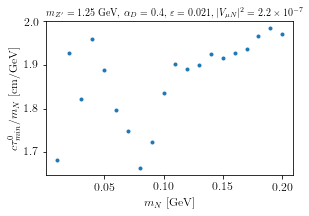

In [56]:
plt.plot(m4_s,
         ctau_min_s/m4_s, 
         '.')
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min} /m_N$ [cm/GeV]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_div_mn_vs_mn.pdf', bbox_inches='tight')

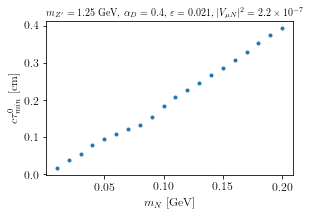

In [57]:
plt.plot(m4_s,
         ctau_min_s, 
         '.')
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn.pdf', bbox_inches='tight')

In [75]:
mz_s = np.linspace(1, 2, 3)
m4_s = np.linspace(0.01, 0.2, 3)
ctau_min_s = []

In [76]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

for mz in mz_s:
    this_point['mz'] = mz
    print(f'mz = {mz}')
    ctau_min_s.append([])
    for m4 in m4_s:
        print(f'm4 = {m4}')
        this_point['m4'] = m4
        this_point['external_ctau'] = np.geomspace(0.001, 10, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        
        ctau_min_s[-1].append(ctau_min)

mz = 1.0
m4 = 0.01
[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
[-0.30663739 -0.30469951 -0.3014361  -0.28232379 -0.1713907   0.32385313
  1.81990605  4.90268    10.2773372  19.83738831 34.98031378 52.94910405
 69.10817452 81.02280027 89.05173607 94.34996948 96.69212032 94.95040236
 88.76763849 78.92179037]
[0.00444277 0.00477905 0.00514078 0.00552988 0.00594844 0.00639869
 0.00688301 0.00740398 0.0079644  0.00856723 0.00921568 0.00991323
 0.01066356 0.01147069 0.01233892 0.01327286 0.01427749 0.01535816
 0.01652063 0.01777108]
[-0.27886947 -0.27053487 -0.25972128 -0.24576755 -0.22785472 -0.20497756
 -0.17591662 -0.13921445 -0.09315998 -0.03578688  0.03510899  0.1219289
  0.22720657  0.35352402  0.50341743  0.6792869   0.88332411

In [78]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['mz'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

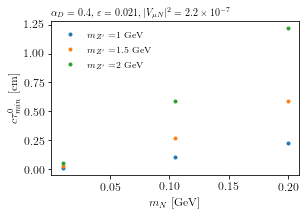

In [80]:
for i, mz in enumerate(mz_s):
    plt.plot(m4_s,
             ctau_min_s[i], 
             '.',
             label=r'$m_{Z^{\prime}}$ = '+f'{mz:.3g} GeV')
    
plt.legend(frameon=False)
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn_mz.pdf', bbox_inches='tight')

## Varying V_muN

In [88]:
Umu4_2_s = [2e-8, 1e-7, 5e-7]
m4_s = np.linspace(0.01, 0.2, 3)
ctau_min_s = []

In [90]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

for Umu4_2 in Umu4_2_s:
    this_point['Umu4_2'] = Umu4_2
    print(f'Umu4_2 = {Umu4_2}')
    ctau_min_s.append([])
    for m4 in m4_s:
        print(f'm4 = {m4}')
        this_point['m4'] = m4
        this_point['external_ctau'] = np.geomspace(0.001, 10, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        
        ctau_min_s[-1].append(ctau_min)

Umu4_2 = 2e-08
m4 = 0.01
[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
[-1.30944584 -1.30957986 -1.30972962 -1.30955667 -1.30575157 -1.28376917
 -1.21102335 -1.04714914 -0.7412019  -0.14488549  1.07847667  3.11986119
  5.63008451  7.85123903  9.40069017 10.34188305 10.61890805 10.00249697
  8.50494359  6.49708658]
[0.04243187 0.04564356 0.04909835 0.05281464 0.05681221 0.06111236
 0.06573799 0.07071373 0.0760661  0.08182358 0.08801686 0.09467891
 0.10184521 0.10955393 0.11784613 0.12676598 0.13636097 0.14668221
 0.15778467 0.16972749]
[-0.84257937 -0.78790351 -0.72765633 -0.6610637  -0.58723025 -0.50514051
 -0.41366637 -0.31158156 -0.19758391 -0.0703256   0.07154884  0.22935748
  0.40433015  0.59755345  0.82760316  1.06105799  1.3

In [92]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

In [94]:
ctau_min_s

[[],
 [0.08491952405258103, 0.8923183303210169, 1.881067492078531],
 [0.027742591261226305, 0.31031759665909164, 0.6133165629715931],
 [0.008539613004478667, 0.11520381807737003, 0.2483787411900989]]

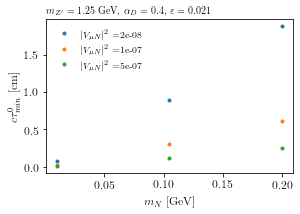

In [96]:
for i, Umu4_2 in enumerate(Umu4_2_s):
    plt.plot(m4_s,
             ctau_min_s[i+1], 
             '.',
             label=r'$|V_{\mu N}|^2$ ='+f'{Umu4_2:.3g}')
    
plt.legend(frameon=False)
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn_Umu4_2.pdf', bbox_inches='tight')

# Geometrical acceptance

In [8]:
ctaus = np.geomspace(1e-2, 1e4, 20)

mu_s = {}
sigma2_s = {}

mu_s_noctau = {}
sigma2_s_noctau = {}

materials = ['lead', 'argon']

for selection in materials:
    mu_s[selection] = 0
    sigma2_s[selection] = 0
    mu_s_noctau[selection] = 0
    sigma2_s_noctau[selection] = 0
    for nu_mode in ['FHC', 'RHC']:
        # general_selection = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].is_point_in_tpc_general([my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base['int_point_x'],
        #                                                                                         my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base['int_point_y'],
        #                                                                                         my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base['int_point_z']],
        #                                                                                        coords=[0,1,2],
        #                                                                                        tpc_index=1)
        aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=ctaus,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s[selection] += aux[1].sum(axis=0)
        sigma2_s[selection] += (aux[1]**2).sum(axis=0)
        
        aux_noctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=None,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s_noctau[selection] += aux_noctau[1].sum(axis=0)
        sigma2_s_noctau[selection] += (aux_noctau[1]**2).sum(axis=0)

In [9]:
from parameters_dict import tpc_total_fiducial_volume, tpc_total_active_volume

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


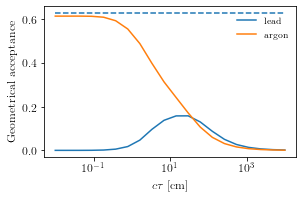

In [10]:
ax = set_canvas_basic()

for selection in materials:     
    ax.plot(ctaus, mu_s[selection]/mu_s_noctau[selection], label=selection)

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.legend(frameon=False, loc='upper right')

ax.hlines(tpc_total_fiducial_volume/tpc_total_active_volume, ctaus[0], ctaus[-1], ls='--')

# plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
# plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)

In [11]:
mu_s[selection]/mu_s_noctau[selection] / (tpc_total_fiducial_volume/tpc_total_active_volume)

array([0.97787972, 0.97785027, 0.9779175 , 0.97674679, 0.96988298,
       0.94426566, 0.88409836, 0.77765731, 0.633945  , 0.49878468,
       0.38522135, 0.27244299, 0.1694805 , 0.09471138, 0.04943098,
       0.02483727, 0.01223677, 0.00596979, 0.00289837, 0.00140386])

In [19]:
aux_binning = []
for i_split, splits in detector_splitting_z.items():
    if i_split in [3, 5, 7]:
        aux_binning += np.linspace(*splits, 20).tolist()
binning_z = np.array(aux_binning)

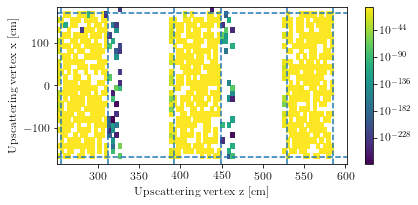

In [26]:
nu_mode = 'FHC'
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']

mask = aux[0].eval(
# this_weights = exp_analysis_obj.compute_pot_ntarget_weights(df, 
#                             ntarget_per_material=analyses['tpc'][nu_mode]['n_target'],
#                             pot=analyses['tpc'][nu_mode]['pot'])


fig = plt.figure(figsize=(6.5,2.9))
plt.hist2d(aux[0]['int_point_z'], aux[0]['int_point_x'], 
          bins=(binning_z, 30), weights=aux[1][:, 0], norm=LogNorm(),
          density=True);

for tpc_index in range(3):
    plt.axvline(tpc_fiducial_volume_endpoints[2][0] + tpc_index * (tpc_outer_volume[2] + fgd_outer_volume[2]), ls='--')
    plt.axvline(tpc_fiducial_volume_endpoints[2][1] + tpc_index * (tpc_outer_volume[2] + fgd_outer_volume[2]), ls='--')
plt.axhline(tpc_fiducial_volume_endpoints[0][0], ls='--')
plt.axhline(tpc_fiducial_volume_endpoints[0][1], ls='--')

plt.xlabel('Upscattering vertex z [cm]')
plt.ylabel('Upscattering vertex x [cm]')
plt.colorbar()

# plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

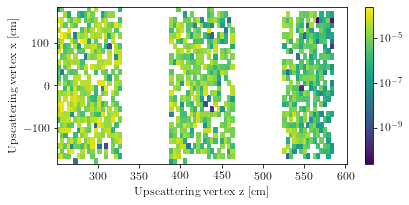

In [21]:
nu_mode = 'FHC'
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']
df = exp_analysis_obj.df_base

# this_weights = exp_analysis_obj.compute_pot_ntarget_weights(df, 
#                             ntarget_per_material=analyses['tpc'][nu_mode]['n_target'],
#                             pot=analyses['tpc'][nu_mode]['pot'])


fig = plt.figure(figsize=(6.5,2.9))
plt.hist2d(aux[0]['int_point_z'], aux[0]['int_point_x'], 
          bins=(binning_z, 30), weights=aux[1][:, -1], norm=LogNorm(),
          density=True);
plt.xlabel('Upscattering vertex z [cm]')
plt.ylabel('Upscattering vertex x [cm]')
plt.colorbar()

# plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

In [12]:
mass_material

{'hydrogen': [0.192,
  0.9909206349206349,
  0.192,
  0.08229343776,
  0.09919338630400001],
 'oxygen': [2.2222222222222223, 0.04138124736, 0.448779801344],
 'carbon': [1.152, 4.2788571428571425, 1.152, 0.96344299584, 0.537580970112],
 'copper': [1.6500000000000001],
 'zinc': [0.8499999999999999],
 'lead': [1.554, 1.554],
 'argon': [0.00534, 0.00534, 0.00534]}

In [13]:
mass_weights

{'hydrogen': array([0.12336101, 0.63667173, 0.12336101, 0.05287397, 0.06373227]),
 'oxygen': array([0.81928769, 0.01525642, 0.16545589]),
 'carbon': array([0.14250581, 0.52930728, 0.14250581, 0.11918075, 0.06650036]),
 'copper': array([1.]),
 'zinc': array([1.]),
 'lead': array([0.5, 0.5]),
 'argon': array([0.33333333, 0.33333333, 0.33333333])}